In [6]:
import numpy as np
try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False
import sys
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

def plotCurve(train_mean, train_std,test_mean,test_std,sizes):
    plt.plot(sizes, train_mean, 
            color='blue', marker='o', 
            markersize=5, 
            label='training accuracy')
    plt.fill_between(sizes, 
                  train_mean + train_std,
                   train_mean - train_std, alpha=0.15, color='blue')

    plt.plot(sizes, test_mean, 
              color='green', linestyle='--', 
              marker='s', markersize=5, 
             label='validation accuracy')
    plt.fill_between(sizes, 
                      test_mean + test_std,
                     test_mean - test_std, 
                    alpha=0.15, color='green')
    plt.xlabel('x_range')
    plt.ylabel('Accuracy')
    plt.show()
def likehoodScore(proba,y):
    return np.sum(proba * y)/proba.shape[0]

def firstNScore(n, pred, y):
    backup = np.array(pred, copy =True)
    for r in range(pred.shape[0]):
        row = backup[r]
        s = np.sort(row)
        for c in range(pred.shape[1]):
            temp = backup[r][c]
            backup[r][c] = False
            for j in range(1,n+1):
                if temp == s[-j]:
                    backup[r][c] = True
                    break
    res = np.sum(np.logical_and(backup,y))/pred.shape[0]
    return res               

def oneHotDecode(self, X_sample):
    result=None
    fiPos = 0
    colIndex = 0
    while colIndex < X_sample.shape[1]:
        if fiPos < len(self.ohe.n_values_) and colIndex == self.ohe.feature_indices_[fiPos]:                
            start = self.ohe.feature_indices_[fiPos]
            end_ = start+ self.ohe.n_values_[fiPos]
            #print("start{} end{}".format(start,end_))
            classes = np.argmax(X_sample[:,start:end_],axis=1).reshape(X_sample.shape[0],1)
            if result is None:
                result = classes
            else:
                result=np.hstack([result,classes])
            colIndex = end_
            fiPos = fiPos +1
        else:
            if result is None:
                result = X_sample[:,colIndex:colIndex+1]
            else:
                result=np.hstack([result, X_sample[:,colIndex:colIndex+1]])
            colIndex = colIndex +1
        
    return result 
def convertToDate(dayStamps):
    res = [] 
    for v in dayStamps:
        res.append(datetime.datetime.fromtimestamp(float(v)*24*60*60))
    return res


    

def precisionMatrix(proba, y):
    def _precisionClassify(df,proba, wins, c =0 ):
        for indx, v in enumerate(proba):
            row = 0
            col = 0
            if wins[indx] == c:
                col = 0
            else:
                col =1
            if v <0.2:
                row =6 
            elif v < 0.3 and  v >=0.2:
                row =5 
            elif v < 0.4 and v >= 0.3:
                row = 4 
            elif v < 0.5 and v >= 0.4:
                row = 3 
            elif v < 0.6 and v >= 0.5:
                row = 2 
            elif v < 0.8 and v >= 0.6:
                row = 1
            df.iloc[row,col] = df.iloc[row,col]+1 
        df[df.columns[2]] = df[df.columns[0]] /(df[df.columns[1]] + df[df.columns[0]])
        return df
    rowHeader = ['>80','60-80','50-60','40-50','30-40','20-30','<20']
    df = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['h_Correct', 'h_Wrong','h_Precent'])
    hproba = proba[:,0]
    wins = np.argmax(y,axis=1)
    df = _precisionClassify(df,hproba,wins)
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['d_Correct', 'd_Wrong','d_Precent'])
    dproba = proba[:,1]
    df = df.join(_precisionClassify(temp,dproba,wins,c=1))
    temp = pd.DataFrame(np.zeros(shape=(7,3)),index=rowHeader, columns=['a_Correct', 'a_Wrong','a_Precent'])
    aproba = proba[:,2]
    df = df.join(_precisionClassify(temp,aproba,wins,c=2))
    
    bound = pd.DataFrame(np.array([[0.8,1.0],[0.6,0.8],[0.5,0.6],[0.4,0.5],[0.3,0.4],[0.2,0.3],[0,0.2]] )
                                ,index=rowHeader, columns=['[lower', 'upper)'])
            
    return bound.join(df)
       
from datetime import date, timedelta
from sklearn.metrics import precision_score


def futureTest(mlp, X,y,numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(X[:,c.dateColumn])
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            mlp.fit(X_train,y_train)
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = mlp.predict_proba(X_test)
            train_proba =mlp.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
            if verbose == True:
                print("week{}".format(w))
                print("numOftest {} , score {}".format(X_test.shape[0],mlp.score(X_test,y_test)))
                print(np.hstack([stack[errorIndx],proba[errorIndx],y_test[errorIndx]]))
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
        
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    return firstNScore(1,sum_train_proba,sum_train_y), score, like2


In [7]:
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
class FootballDataHelper:
    def __init__ (self, recentNum=5):
        self.win_mapping = {'H':0, 'D':1,'A':2}
        self.recentNum = recentNum
        self.df = None
        self.teamsData={}
        self.session = 0
        self.generalList =['HS','AS','HST','AST','H_poss' ,'A_poss' ,'H_atk_3rd', 'A_atk_3rd',
 'H_atk_3rd_tot', 'A_atk_3rd_tot','H_red_goal' ,'A_red_goal' ,'H_red_on',
 'A_red_on' ,'H_red_tot' ,'A_red_tot' ,'H_chance_goal' ,'A_chance_goal',
 'H_chance_tot', 'A_chance_tot' ,'H_successful_tackle', 'A_successful_tackle',
 'H_tackle_tot', 'A_tackle_tot', 'H_successful_clearance',
 'A_successful_clearance', 'H_clearance_tot' ,'A_clearance_tot',
 'H_interceptions' ,'A_interceptions', 'H_blocks', 'A_blocks']
        self.percentList = ['atk_3rd','atk_3rd_tot','red_goal','red_tot','red_on','red_tot',
                           'chance_goal','chance_tot','successful_tackle','tackle_tot',
                            'successful_clearance','clearance_tot']
       
    def addColumns(self,df, addition):    
        dates = df["Date"].drop_duplicates().values
        col_adds = []
        for colAdd in addition.columns:
             if colAdd not in df.columns:
                    df[colAdd]=np.zeros(shape=(df.shape[0],))
                    col_adds.append(colAdd)
        for date in dates:
            dateAddition= addition[addition['Date'] == date].sort(columns='HomeTeam')
            dateDf  = df [df['Date']==date].sort(columns='HomeTeam')
            for col in col_adds:
                dateDf[col] = dateAddition[col].values
            df.update(dateDf)
        return df
            
    def saveDf(self,filename):
        self.df.to_csv(filename,index=False)
    def loadDf(self,filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'])    
        self.df = df
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
    def readFootBallData(self,year): 
        filename = "dataSet/E{}.csv".format(year)
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'])
        df['session'] = pd.Series(np.ones(shape=(df.shape[0],))*self.session, index=df.index)
        self.session = self.session +1
        
        matchDetail = pd.read_csv("dataSet/match{}.csv".format(year))
        matchDetail['Date'] =pd.to_datetime(matchDetail['Date'])
        df = self.addColumns(df,matchDetail)
        
        df["Future"] = np.zeros(shape=(df.shape[0],))
        
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
    def readFuture(self):
        filename = "dataSet/future.csv"
        df = pd.read_csv(filename)
        #df = df.drop(df.columns[range(23,df.shape[1])], axis=1)
        #df = df.drop("Div",axis=1)
        df['Date'] = pd.to_datetime(df['Date'])
        df["Future"] = np.ones(shape=(df.shape[0],))
        if self.df is None:
            self.df = df
        else:
            self.df = pd.concat([self.df,df])
            
        self.df['HTR']=self.df['HTR'].fillna('D')
        self.df = self.df.fillna(0)
        self.df = self.df.reset_index(drop=True)
        teams = self.df['HomeTeam'].drop_duplicates()
        teamMap = {}
        for index , v in enumerate(teams):
            teamMap[v] = index
        self.teamsMap = teamMap
        referees = self.df['Referee'].drop_duplicates()
        refereesMap = {}
        for index , v in enumerate(referees):
            refereesMap[v] = index+1

        self.refereesMap = refereesMap
        
    def getTeam(self,dataFrame, teamName):       
        return dataFrame[(dataFrame["HomeTeam"] == teamName) | (dataFrame["AwayTeam"] == teamName)]
 
        
    def previousRecords(self,team, date , recentNum):
        prev = team[( team["Date"] < date)]
        
        if prev.shape[0] < recentNum :
            #print("less than min Num")
            return None
        else:
            return prev.iloc[-recentNum:]
    def readPredict (self, filename):
        df = pd.read_csv(filename)
        df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

        return df
    
    
  
    def inverseTeamMapping (self, col):
        inverseMap ={}
        for name in self.teamsMap.keys():        
            inverseMap[self.teamsMap[name]] = name
        res =[]
        for idex, v in enumerate(col):
            res.append(inverseMap[v])
        return res


    def readTeamMatch(self, teamName):
        df = pd.read_csv('teams/'+teamName+'.csv')
        df['1'] = pd.to_datetime(df['1'],yearfirst=True)
        #df['1']= (pd.to_numeric(df['1'])/1e9/24/60/60)
        self.teamsData[teamName]=df.sort(['1'],ascending=[False])
        self.teamsById[self.teamsMap[teamName]]=self.teamsData[teamName]
    
    def commonMapping(self, X):
        X['HomeTeam'] = X['HomeTeam'].map(self.teamsMap)
        X['AwayTeam'] = X['AwayTeam'].map(self.teamsMap)
        X['Referee']=X['Referee'].map(self.refereesMap).fillna(0)
        X['HTR'] = X['HTR'].map(self.win_mapping)
        X['FTR'] = X['FTR'].map(self.win_mapping)
        return X
    def initData(self, X, target,encode):
        X  = X.sort_values(by="Date")
        isInput = False
        if target is None:
            target =X      
        else:
            if self.ohe is None:
                raise Exception("Not yet get train data")
            isInput = True
            if encode == True:
                target = self.commonMapping(target)
        y=None
        if encode == True:    
            X =self.commonMapping(X)
            y = []
            for v in target['FTR']:
                y.append(range(3)==v)
        else:
            y = target['FTR'].values
        target_date = (pd.to_numeric(target['Date'])/1e9/24/60/60).values
        return isInput, X,y, target, target_date
   
    def aggregate(self,recents,nonExpand,isInput,encode):
        res =None
        if encode == True:
            if isInput==False:
                self.ohe = OneHotEncoder(categorical_features='all')
                self.ohe.fit(recents)
            res = self.ohe.transform(recents).toarray()
        else:
            res = np.array(recents)
        self.dateColumn = res.shape[1]
        res = np.hstack([res,nonExpand])
        return res
  
    def getH7(self,removeInsufficient=True, target=None,encode = True,future =0):
        #Simple recent win,draw, lose 
        df = self.df
        if removeInsufficient == True:
            df= df[df['Sufficient'] == 1]
        df=df[df['Future']==future]
        
        isInput, X, y,target, target_date = self.initData(df,target,encode)
        resy=[]
        resx=[]
        print("start format")
        recents = X[['HomeTeam','AwayTeam','Referee']].values
        haccp = X['HAccP'].values.reshape(X.shape[0],1)
        aaccp = X['AAccP'].values.reshape(X.shape[0],1)
        homeRecent = np.hstack([X[['HWin','HDraw','HLose']].values,
                                (X['HScore'].values - X['HConcede'].values).reshape(X.shape[0],1)])
        awayRecent = np.hstack([X[['AWin','ADraw','ALose']].values,
                                (X['AScore'].values - X['AConcede'].values).reshape(X.shape[0],1)])
        homeMoral = X['HMoral'].values.reshape(X.shape[0],1)
        awayMoral = X['AMoral'].values.reshape(X.shape[0],1)
        target_date = target_date.reshape(X.shape[0],1)
        
        
        
        
        acc_headers = [e+'_Acc' for e in self.generalList]
        self.acc_headers= acc_headers
        general = X[['HRestDay','ARestDay']+acc_headers].values
        
        ha_headers =np.array(acc_headers).reshape(len(acc_headers)/2, 2).T
        print(ha_headers)
        h_over_a = (X[ha_headers[0,:]].values/X[ha_headers[1,:]].values)
        self.ha_headers = [ ha_headers[0,i]+'/'+ha_headers[1,i] for i in range(ha_headers.shape[1])]
        
        percent_headers =[]
        percent_headers += ['H_'+e+'_Acc' for e in self.percentList]
        percent_headers += ['A_'+e+'_Acc' for e in self.percentList]
        n_percent_headers = np.array(percent_headers).reshape(len(percent_headers)/2, 2).T
        percent_values = (X[n_percent_headers[0,:]].values/X[n_percent_headers[1,:]].values)
        self.percent_headers = [ n_percent_headers[0,i]+'/'+n_percent_headers[1,i] for i in range(n_percent_headers.shape[1])]
        
        nonExpand =np.hstack([target_date,haccp-aaccp,(haccp+1)/(aaccp+1),
                            homeRecent,awayRecent, 
                              homeMoral - awayMoral + haccp - aaccp, X[['H_Enemy_Acc','A_Enemy_Acc']].values,
                              general, percent_values
                             ])
        res = self.aggregate(recents,nonExpand,future,encode)
        print("finish")
        sys.stdout.flush()
        return res, np.array(y)
    def _getRank(self,x, X,teamName,recentNum):
        team = self.getTeam(X,teamName)
        prev = team[team['Date'] < x['Date']].values      
        for i in range(recentNum):
            pass
    def initRanking(self, n = 20):
        defaultPt = 1
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HPoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["APoints"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AAccP"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        hpoints= df["HPoints"].values
        apoints=df["APoints"].values
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hpoints[i] = 3
                apoints[i] = 0
            elif ftr[i] == 'D':
                hpoints[i] = 1
                apoints[i] = 1
            else :
                hpoints[i] = 0
                apoints[i] = 3
        df["HPoints"]=hpoints
        df["APoints"]=apoints
        for teamName in self.teamsMap.keys():
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hpoints = team['HPoints'].values
            apoints = team['APoints'].values
            psum = 0
            haccp = team['HAccP'].values
            aaccp = team['AAccP'].values
        
            for  i in range(0,n):
                if i < hpoints.shape[0]:
                    psum = psum + (hpoints[i] if hometeam[i] == teamName else apoints[i] ) 
                else:
                    psum = psum + defaultPt        
                    
        
            for j in range(team.shape[0]):

                if j+n < hpoints.shape[0]:                     
                    psum = psum + (hpoints[j+n] if hometeam[j+n]==teamName else apoints[j+n])
                else:
                    psum = psum + defaultPt 
                
                psum = psum - (hpoints[j] if hometeam[j]==teamName else apoints[j])
                    
                if hometeam[j] == teamName:
                    haccp[j]=psum
                else:
                    aaccp[j]=psum
            team['HAccp']=haccp
            team['AAccP']=aaccp
            #print(team[['HomeTeam','AwayTeam','HAccP','AAccP']])
            df.update(team)
            
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initRecentData(self, n =5):
        df = self.df.sort(columns=["Date"],ascending=[False])
        df["HWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AWin"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HDraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ADraw"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HLose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ALose"] = pd.Series(np.zeros(shape=(df.shape[0],)))
                
        df["HScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AScore"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AConcede"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["AMoral"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["HRestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["ARestDay"]= pd.Series(np.zeros(shape=(df.shape[0],)))
        df["H_Enemy_Acc"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        df["A_Enemy_Acc"] = pd.Series(np.zeros(shape=(df.shape[0],)))
        #general
        generalList = self.generalList 
        generalOutput = []
        for attr in generalList:
            temp = attr+'_Acc'
            df[temp]=pd.Series(np.zeros(shape=(df.shape[0],)))
            generalOutput.append(temp)
        #
        df["Sufficient"] = pd.Series(np.ones(shape=(df.shape[0],)))
        
      
            
        
        hscore = df['FTHG'].values
        ascore = df['FTAG'].values
        hconcede = df ['FTAG'].values
        aconcede = df['FTHG'].values
               
        hwin = df['HWin'].values
        awin = df['AWin'].values
        hlose = df['HLose'].values
        alose = df['ALose'].values
        hdraw = df['HDraw'].values
        adraw = df['ADraw'].values
        hmoral = df['HMoral'].values
        amoral = df['AMoral'].values
        
        rankRatio = (df['HAccP'].values+1) / (df['AAccP'].values +1)
        
        
        ftr = df["FTR"].values
        for i in range(df.shape[0]):
            sys.stdout.write("\r progress {}".format(i))
            sys.stdout.flush()
            if ftr[i] == 'H':
                hwin[i] = 1
                hmoral[i] = 3 * 1/rankRatio[i]
                alose[i]= 1
                amoral[i] = -3 * 1/rankRatio[i]
            elif ftr[i] == 'D':
                hdraw[i] = 1
                hmoral[i] = 1 * 1/rankRatio[i]
                adraw[i] = 1
                amoral[i] = 1 * rankRatio[i]
            else :
                hlose[i] = 1
                hmoral[i] = -3*rankRatio[i]
                awin [i] = 1
                amoral[i] = 3*rankRatio[i]
        
        
        df["HWin"]=hwin
        df["AWin"]=awin
        df["HDraw"]=hdraw
        df["ADraw"]=adraw
        df["HLose"]=hlose
        df["ALose"]=alose
        df["HScore"]=hscore
        df["AScore"]=ascore
        df["HConcede"]=hconcede
        df["AConcede"]=aconcede
        df["HMoral"] = hmoral
        df["AMoral"] = amoral
        
        
        
        for teamName in self.teamsMap.keys():
            print(teamName)
            team  = df[(df['HomeTeam']==teamName) | (df['AwayTeam'] == teamName)] 
            hometeam = team['HomeTeam'].values
            hwin = team["HWin"].values
            awin = team["AWin"].values
            hlose= team["HLose"].values
            alose = team["ALose"].values
            hdraw = team["HDraw"].values
            adraw = team["ADraw"].values
            hscore = team["HScore"].values
            ascore = team["AScore"].values
            hconcede = team["HConcede"].values
            aconcede = team["AConcede"].values
            hmoral = team["HMoral"].values
            amoral = team["AMoral"].values
            hrestday = team["HRestDay"].values
            arestday = team["ARestDay"].values
            
            haccp = team["HAccP"].values
            aaccp = team["AAccP"].values
            h_enemy = team["H_Enemy_Acc"].values
            a_enemy = team["A_Enemy_Acc"].values
            enemy_sum = 0
            
            #general
            original_list =[]
            output_list=[]
            for indx, o_attr in enumerate(generalList):
                original_list.append(team[o_attr].values)
                output_list.append(team[generalOutput[indx]].values)
            
            
            matchDate =team['Date'].values
            sufficient = team['Sufficient'].values
            teamMatchesDate = self.teamsData[teamName].sort('1',ascending=False)['1'].values
            
            restday = 0
            winsum =0 
            losesum=0
            drawsum=0
            scoresum =0
            concedesum=0
            moralsum = 0
            #print(team[['HomeTeam','AwayTeam','HWin']])
            teamAttrSum_list=[0 for i in range(int(len(original_list)/2))]
            for  i in range(0,n):
                if i < team.shape[0]:
                    scoresum = scoresum + (hscore[i] if hometeam[i] == teamName else ascore[i])
                    winsum = winsum + (hwin[i] if hometeam[i] == teamName else awin[i])
                    losesum= losesum + (hlose[i] if hometeam[i] == teamName else alose[i])
                    drawsum= drawsum + (hdraw[i] if hometeam[i] == teamName else adraw[i])
                    concedesum = concedesum+ (hconcede[i] if hometeam[i] == teamName else aconcede[i])
                    moralsum= moralsum+ (hmoral[i] if hometeam[i] == teamName else amoral[i])
                    enemy_sum += (aaccp[i] if hometeam[i] == teamName else haccp[i])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] +=(original_list[2*attrIndx][i] if hometeam[i] == teamName else original_list[2*attrIndx+1][i])
                else:
                    # + 0
                    pass
            dateIndx = 0
            for j in range(team.shape[0]):
                while True:
                    if dateIndx >= teamMatchesDate.shape[0]:
                        sufficient[j] = False
                        break
                    if teamMatchesDate[dateIndx] < matchDate[j] :
                        restday = (matchDate[j] - teamMatchesDate[dateIndx])/np.timedelta64(1,'D')
                        break
                    else:
                        dateIndx = dateIndx + 1
                
                if j+n < team.shape[0]:                     
                    scoresum = scoresum + (hscore[j+n] if hometeam[j+n] == teamName else ascore[j+n])
                    winsum = winsum + (hwin[j+n] if hometeam[j+n] == teamName else awin[j+n])
                    losesum= losesum + (hlose[j+n] if hometeam[j+n] == teamName else alose[j+n])
                    drawsum= drawsum + (hdraw[j+n] if hometeam[j+n] == teamName else adraw[j+n])
                    concedesum = concedesum+ (hconcede[j+n] if hometeam[j+n] == teamName else aconcede[j+n])
                    moralsum= moralsum+ (hmoral[j+n] if hometeam[j+n] == teamName else amoral[j+n])
                    enemy_sum += (aaccp[j+n] if hometeam[j+n] == teamName else haccp[j+n])
                    for attrIndx in range(len(teamAttrSum_list)):
                        teamAttrSum_list[attrIndx] += (original_list[2*attrIndx][j+n] if hometeam[j+n] == teamName else original_list[2*attrIndx+1][j+n])
                else:
                    sufficient[j] = False
                    
                
                scoresum = scoresum - (hscore[j] if hometeam[j] == teamName else ascore[j])
                winsum = winsum - (hwin[j] if hometeam[j] == teamName else awin[j])
                losesum= losesum - (hlose[j] if hometeam[j] == teamName else alose[j])
                drawsum= drawsum - (hdraw[j] if hometeam[j] == teamName else adraw[j])
                concedesum = concedesum - (hconcede[j] if hometeam[j] == teamName else aconcede[j])
                moralsum= moralsum - (hmoral[j] if hometeam[j] == teamName else amoral[j])
                enemy_sum -= (aaccp[j] if hometeam[j] == teamName else haccp[j])
                for attrIndx in range(len(teamAttrSum_list)):
                    teamAttrSum_list[attrIndx] -=  (original_list[2*attrIndx][j] if hometeam[j] == teamName else original_list[2*attrIndx+1][j])
                    
                if hometeam[j] == teamName:
                    hscore[j] = scoresum
                    hwin[j] = winsum
                    hlose[j] = losesum
                    hdraw[j] = drawsum
                    hconcede[j] = concedesum
                    hmoral[j] = moralsum
                    hrestday[j] = restday
                    h_enemy[j] = enemy_sum
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx][j] = teamAttrSum_list[attrIndx]
                else:
                    ascore[j] = scoresum
                    awin[j] = winsum
                    alose[j] = losesum
                    adraw[j] = drawsum
                    aconcede[j] = concedesum
                    amoral[j] = moralsum
                    arestday[j] = restday
                    a_enemy[j] = enemy_sum
                    for attrIndx in range(len(teamAttrSum_list)):
                        output_list[2*attrIndx+1][j] = teamAttrSum_list[attrIndx]
            team["HWin"]=hwin
            team["AWin"]=awin
            team["HDraw"]=hdraw
            team["ADraw"]=adraw
            team["HLose"]=hlose
            team["ALose"]=alose
            team["HScore"]=hscore
            team["AScore"]=ascore
            team["HConcede"]=hconcede
            team["AConcede"]=aconcede
            team["HMoral"] = hmoral
            team["AMoral"] = amoral
            team['Sufficient'] = sufficient
            team["H_Enemy_Acc"] = h_enemy
            team["A_Enemy_Acc"] = a_enemy
            for indx in range(len(output_list)):
                team[generalOutput[indx]]= output_list[indx]
        
            #print(team[['HomeTeam','AwayTeam','HWin']])
            df.update(team)
            #print(df[['HomeTeam','AwayTeam','HAccP','AAccP']])
        self.df =df
        return df
    def initTeamData(self):
        self.teamsData={}
        self.teamsById={}
        for name in self.teamsMap.keys():
            self.readTeamMatch(name)
            

In [8]:

c = FootballDataHelper()

In [24]:
#c.readFootBallData("E0_1112.csv")
c.readFootBallData(2012)
c.readFootBallData(2013)
c.readFootBallData(2014)
c.readFootBallData(2015)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [25]:

c.readFuture()

In [26]:

c.initTeamData()
clear_output()

In [27]:
df = c.initRanking()
clear_output()

In [28]:
df=c.initRecentData(n=5)
clear_output()

In [29]:
c.saveDf('dataSet/df.csv')

In [9]:
c.loadDf('dataSet/df.csv')

In [92]:
X,y = c.getH7(removeInsufficient=True, encode=False)


start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [93]:
print(X.shape)
df = pd.DataFrame(np.hstack([X,y.reshape(y.shape[0],1)]))

df.columns = ['home','away','Referee','time',
              'HAccP - AAccP','H/A','HWin','HDraw','HLose','H goal Diff',
'AWin','ADraw','ALose','A goal diff','moraldiff + h-a','H_Enemy_Acc','A_Enemy_Acc','HRestDay','ARestDay']+c.acc_headers+\
            c.percent_headers+[
              'y']
print(df)

(1358, 63)
                home         away        Referee   time HAccP - AAccP  \
0             Fulham     Man City       M Halsey  15612             0   
1            Norwich    Liverpool        M Jones  15612             1   
2            Everton  Southampton      L Probert  15612             7   
3              Stoke      Swansea         J Moss  15612            -3   
4            Arsenal      Chelsea     M Atkinson  15612            -4   
5         Man United    Tottenham          C Foy  15612             4   
6        Aston Villa    West Brom       A Taylor  15613            -6   
7                QPR     West Ham  M Clattenburg  15614            -6   
8              Wigan      Everton       K Friend  15619            -9   
9          West Brom          QPR        M Jones  15619             9   
10          Man City   Sunderland      L Probert  15619             4   
11           Chelsea      Norwich       A Taylor  15619            13   
12          West Ham      Arsenal       

In [94]:

df.to_csv('dataSet/V10_2.csv',index=False)

In [10]:
X,y = c.getH7(removeInsufficient = True)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [12]:
from sklearn.cross_validation import train_test_split
def splitData(X,y):
    X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
    X_test, X_val, y_test,y_val = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
from keras.models import Sequential


Using Theano backend.
/home/y/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [113]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
def createModel(hidSize, inputDim ,dropout =0.4):
    activation ='sigmoid'
    model = Sequential()
    model.add(Dense(hidSize[0], input_dim=inputDim, init='glorot_normal'))
    model.add(Activation(activation))
    model.add(Dropout(dropout))

    model.add(Dense(hidSize[1], init='glorot_normal'))
    model.add(Activation(activation))
    model.add(Dropout(dropout))
 
    model.add(Dense(3, init='glorot_normal'))
    model.add(Activation('softmax'))
    sgd = SGD(lr=0.03, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    return model
earlyCallback = EarlyStopping(patience=20,verbose=1)

In [133]:
g_best_size = 52
g_best_dropout=0.4
g_patience=10

In [71]:
from sklearn.cross_validation import StratifiedKFold
def crossValidate2(node_sizes, X,y,dropout=0.7, fold = 10, earlyStopping =True):
    y_label = np.argmax(y,axis=1)

    kfold = StratifiedKFold(y=y_label, 
                             n_folds=fold,
                            random_state=1)

    scores = []
    train_scores=[]
    proba_test = []
    proba_y=[]
    histories = []
    for k, (train, test) in enumerate(kfold):
        earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
        model = createModel(node_sizes,X.shape[1],dropout=dropout)
        if earlyStopping==True:
            history = model.fit(X[train],y[train],verbose=0,nb_epoch=500, validation_split=0.1,show_accuracy=True, callbacks=[earlyCallback])
            histories.append(history)
        else:
            history = model.fit(X[train],y[train],verbose=0,nb_epoch=500, validation_split=0.1,show_accuracy=True )
            histories.append(history)
      #  firstNScores.append(firstNScore(2, model.predict_proba(X[test]), y[test]))
        score = model.evaluate(X[test],y[test])
        proba_test.append(model.predict_proba(X[test]))
        proba_y.append(y[test])
        train_scores.append(model.evaluate(X[train],y[train]))
        scores.append(score)
        print('Fold: %s, Class dist.: %s, val_loss: %.3f' % (k+1, 
                    np.bincount(y_label[train]), score))    
        
        
    return train_scores,scores, proba_test,proba_y,histories




In [72]:
train_scores,scores,  proba_test,proba_y,histories= crossValidate2([20,20],X_scaled,y,fold=5,dropout=0,earlyStopping=False)

1085/1085 [==============================] - 0s     
Fold: 1, Class dist.: [479 265 341], val_loss: 1.133
1085/1085 [==============================] - 0s     
Fold: 2, Class dist.: [479 265 341], val_loss: 1.031
1087/1087 [==============================] - 0s     
Fold: 3, Class dist.: [479 266 342], val_loss: 1.088
1087/1087 [==============================] - 0s     
Fold: 4, Class dist.: [479 266 342], val_loss: 1.109
1088/1088 [==============================] - 0s     
Fold: 5, Class dist.: [480 266 342], val_loss: 1.256


In [110]:
def dropoutTest() :
    mins = []
    for d in np.arange(0,0.8,0.1):
        model = createModel([5,5],X_scaled.shape[1],dropout=float(d))
        history = model.fit(X_scaled,y,verbose=0,nb_epoch=500, validation_split=0.2,show_accuracy=True )
        mins.append(np.min(history.history['val_loss']))
        n_range = range(len(history.history['loss']))
        losses = history.history['loss']
        plt.plot(n_range,losses)
        plt.plot(n_range,history.history['val_loss'])
        plt.figure()
    return mins
                    
    


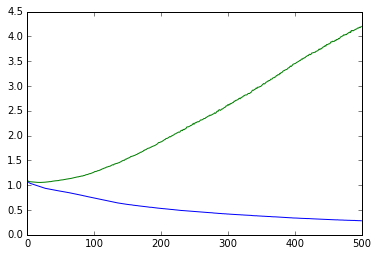

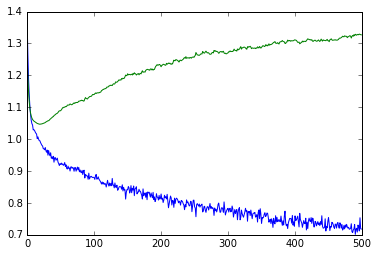

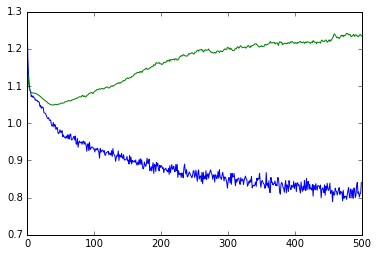

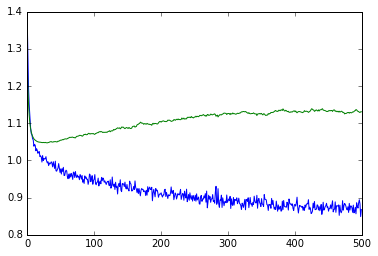

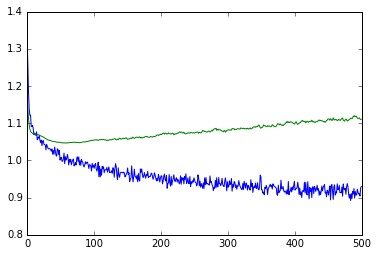

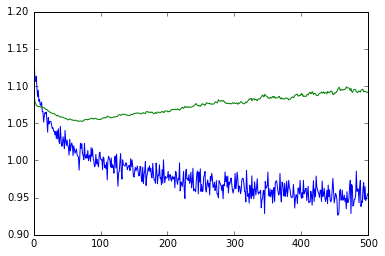

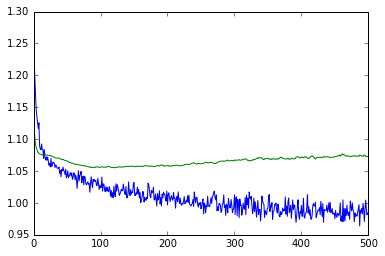

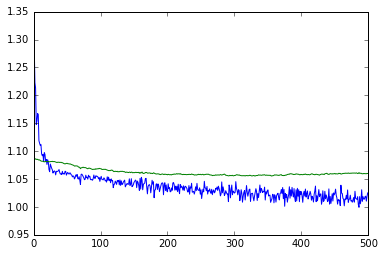

In [111]:
mins = dropoutTest()

[1.05411275695352,
 1.0468871453229118,
 1.0489633924820845,
 1.0472185050739962,
 1.0466017582837273,
 1.0525040907018326,
 1.054951176923864,
 1.055355478735531]

In [117]:
def testNodeNum(X,y, sizes,dropout =0.4):
    #train_loss=[] 
    val_loss=[]
    for s in sizes:
        earlyCallback = EarlyStopping(patience=20,verbose=1)
        model = createModel([s,s],X_scaled.shape[1],dropout=dropout)
        history = model.fit(X,y,verbose=0,nb_epoch=500, validation_split=0.2,show_accuracy=True )
        print("size:{} , min_train:{} min_val_loss:{}".format(s,
                                np.min(history.history['loss']), np.min(history.history['val_loss'])))
        #train_loss.append(np.min(history.history['loss']))
        val_loss.append(np.min(history.history['val_loss']))
    return val_loss

In [123]:
sizes= range(45,55,1)
val_loss= testNodeNum(X_scaled,y,sizes,dropout=0.4)

size:45 , min_train:0.4673106314178769 min_val_loss:1.0501313770518583
size:46 , min_train:0.4741771516439884 min_val_loss:1.0457212363972384
size:47 , min_train:0.43245855824503887 min_val_loss:1.0428246540181778
size:48 , min_train:0.4698984333164784 min_val_loss:1.0449012798421524
size:49 , min_train:0.44447491280940354 min_val_loss:1.045117364210241
size:50 , min_train:0.43796529388998534 min_val_loss:1.0443289911045748
size:51 , min_train:0.43571429928802435 min_val_loss:1.0468077589483822
size:52 , min_train:0.44060084240212627 min_val_loss:1.0400034750209135
size:53 , min_train:0.4384513141700576 min_val_loss:1.0465998088612276
size:54 , min_train:0.42822209071937406 min_val_loss:1.048489907208611


range(45, 55)
min: 52


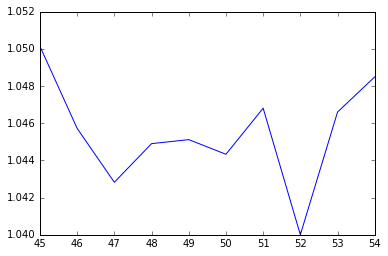

In [124]:
print(sizes)
plt.plot(sizes,val_loss)
plt.figure()
print("min: {}".format(sizes[np.argmin(val_loss)]))

In [ ]:
def testDropoutRate(X,y, sizes,dropout):
    train_scores,scores,  proba_test,proba_y= crossValidate2(sizes,X,y,fold=5,dropout=dropout,earlyStopping=True)
    print("dropout:{} , val_loss_mean:{}".format(dropout,np.mean(scores)))
    return train_scores,scores

In [ ]:
g_dropout_range =np.arange(0.1,1, 0.1)
g_train_loss=[]
g_score_loss =[]
for d in g_dropout_range:
    train_loss, score_loss = testDropoutRate(X_scaled,y,[55,55],float(d))
    g_train_loss.append(train_loss)
    g_score_loss.append(score_loss)

In [ ]:
import matplotlib.pyplot as plt
g_train_mean = np.mean(g_score_loss,axis=1)
g_test_mean = np.mean(g_score_loss,axis=1)
g_test_std = np.std(g_score_loss,axis = 1)
plt.plot(g_dropout_range,g_test_mean)
plt.plot(g_dropout_range,g_train_mean,color='red')
plt.fill_between(g_dropout_range, g_test_mean - g_test_std, g_test_mean+g_test_std,alpha=0.3)
plt.figure()


In [193]:

def futureTest2(node_sizes, X,y,ori_dates, numOfWeek = 10,verbose=False):
    decoded = oneHotDecode(c, X)
    dates = convertToDate(ori_dates)
    dates = [d - timedelta(days=2) for d in dates]    
    weeks  = [ v.isocalendar()[1] for v in dates]
    thisWeek = weeks[-1]
    start = -1
    last = X.shape[0]
    index = -1
    w = 0
    sum_proba =None 
    sum_y =None
    sum_train_proba=None
    sum_train_y=None
    model = createModel(node_sizes,X.shape[1],dropout=g_best_dropout)
    results = None
    while w < numOfWeek:
        if thisWeek != weeks[index]:
            print("week{}".format(w))
            start = X.shape[0] +index+1
            X_train = X[0:start, :]
            X_test = X[start:last,:]
            y_train = y[0:start,:]
            y_test = y[start:last,:]
            earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
            history = model.fit(X_train,y_train,verbose=0,nb_epoch=500, validation_split=0.1, callbacks=[earlyCallback])
            decoded = oneHotDecode(c,X_test)
            home = np.array([c.inverseTeamMapping(decoded[:,0])]).reshape(X_test.shape[0],1)
            away = np.array([c.inverseTeamMapping(decoded[:,1])]).reshape(X_test.shape[0],1)
            stack = np.hstack([home,away])
            proba = model.predict_proba(X_test)
            train_proba =model.predict_proba(X_train)
            errorIndx = np.argmax(proba,axis=1) != np.argmax(y_test,axis=1)
            tresult = np.hstack([np.array([w for i in range(proba.shape[0])]).reshape(proba.shape[0],1),
                                 ori_dates[start:last].reshape(proba.shape[0],1),stack,proba,y_test])
            if sum_proba is None:
                sum_proba = proba
                sum_y = y_test
                sum_train_proba = train_proba
                sum_train_y = y_train
                results =    tresult
            else:
                sum_proba = np.vstack([sum_proba,proba])
                sum_y = np.vstack([sum_y,y_test])
                sum_train_proba = np.vstack([sum_train_proba, train_proba])
                sum_train_y= np.vstack([sum_train_y, y_train])
                results =  np.vstack([results, tresult])
            if verbose == True:
                print("numOftest {} , loss {}".format(X_test.shape[0],model.evaluate(X_test,y_test)))               
                print (tresult)
                print("first2 : {}",firstNScore(2,proba,y_test))
            last = start
            thisWeek = weeks[index]
            w = w+1
        index = index -1
    start = X.shape[0] +index+1
    print("start compute precision_mat")
    print(X[0:start,:].shape)
    print(y[0:start,:].shape)
    _,_, proba_test,proba_y,_ = crossValidate2(node_sizes,X[0:start,:],y[0:start,:],fold=10,dropout=g_best_dropout)
    p_matrix = precisionMatrix(np.vstack(proba_test),np.vstack(proba_y))
    print("summary")
    print("score:")
    score = firstNScore(1,sum_proba,sum_y)
    print(score)
    print("2like")
    like2 = firstNScore(2,sum_proba,sum_y)
    print(precisionMatrix(sum_proba,sum_y))
    y_true= np.argmax(sum_y,axis=1)
    y_pred = np.argmax(sum_proba,axis=1)
    print("sum precision:{}".format(precision_score(y_true,y_pred,average=None)))
    resultdf= pd.DataFrame(results, columns=['week','DayStamp','HomeTeam','AwayTeam','H_prob','D_prob','A_prob','H','D','A'])
    return sum_proba, sum_y,resultdf,p_matrix

In [194]:
sum_proba, sum_y,resultdf,p_matrix= futureTest2([g_best_size,g_best_size],X_scaled,y,X[:,c.dateColumn],numOfWeek=25,verbose=False)

week0
Epoch 00017: early stopping
1348/1348 [==============================] - 0s     
week1
Epoch 00017: early stopping
1343/1343 [==============================] - 0s     
week2
Epoch 00011: early stopping
1328/1328 [==============================] - 0s     
week3
Epoch 00015: early stopping
1315/1315 [==============================] - 0s     
week4
Epoch 00011: early stopping
1305/1305 [==============================] - 0s     
week5
Epoch 00012: early stopping
1293/1293 [==============================] - 0s     
week6
Epoch 00011: early stopping
1285/1285 [==============================] - 0s     
week7
Epoch 00011: early stopping
1275/1275 [==============================] - 0s     
week8
Epoch 00011: early stopping
1258/1258 [==============================] - 0s     
week9
Epoch 00013: early stopping
1255/1255 [==============================] - 0s     
week10
Epoch 00012: early stopping
1244/1244 [==============================] - 0s     
week11
Epoch 00011: early stopping
1225/12

In [195]:
p_matrix

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,7,5,0.583333,0,0,NaN,0,0,NaN
60-80,0.6,0.8,211,96,0.687296,0,0,NaN,45,17,0.725806
50-60,0.5,0.6,74,68,0.521127,0,0,NaN,69,56,0.552000
40-50,0.4,0.5,69,79,0.466216,0,0,NaN,65,88,0.424837
30-40,0.3,0.4,64,107,0.374269,55,104,0.345912,52,117,0.307692
20-30,0.2,0.3,37,134,0.216374,174,534,0.245763,53,149,0.262376
<20,0.0,0.2,27,118,0.186207,35,194,0.152838,59,326,0.153247


In [196]:
def findRecordsBy(self,df):
    #print((df['DayStamp']).values)
    #date = convertToDate((df['DayStamp']).values)
    #df["Date"] = date
    
    home = df['HomeTeam'].values
    away = df['AwayTeam'].values
    origin = self.df[["Date","HomeTeam","AwayTeam","JocH","JocD","JocA"]]
    origin["DayStamp"]=(pd.to_numeric(origin['Date'])/1e9/24/60/60).values
    origin["DayStamp"] = origin["DayStamp"].apply(lambda x: "%.f"%(float(x)))
    df['DayStamp']=df['DayStamp'].apply(lambda x: "%.f"%(float(x)))
    return origin.merge(df,left_on=['DayStamp',"HomeTeam","AwayTeam"],right_on=["DayStamp","HomeTeam","AwayTeam"],how='inner')
   
  

In [197]:
withodds = findRecordsBy(c,resultdf)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [198]:
import math
def formatMatrixs(oddDf , precisionDf):
    proba_mat = oddDf[['H_prob','D_prob','A_prob']].values
    def locatePrecision(proba_mat, precisionDf):
        precisionMat = precisionDf.values
        pre_cols=[4,7,10]
        def convert(proba, pre_col = 4):
            if proba < 0.2:
                return proba
            for i in range(precisionMat.shape[0]):
                if precisionMat[i,0] <= proba and proba < precisionMat[i,1] :
                    if math.isnan(precisionMat[i,pre_col]):
                        return proba
                    else:
                        return precisionMat[i,pre_col]
        h_fproba = np.array([ convert(float(proba)) for proba in proba_mat[:,0] ] )
        d_fproba = np.array([ convert(float(proba),pre_col=7) for proba in proba_mat[:,1] ] )
        a_fproba = np.array([ convert(float(proba),pre_col=10) for proba in proba_mat[:,2] ] )
        return h_fproba, d_fproba,a_fproba
    h_fproba, d_fproba,a_fproba =locatePrecision(proba_mat,precisionDf)
    fproba_mat = np.hstack([h_fproba,d_fproba,a_fproba]).reshape(3,h_fproba.shape[0]).T
    odd_mat = oddDf[['JocH','JocD','JocA']].values
    win_mat = None
    if 'H' in oddDf.columns:
        win_mat = oddDf[['H','D','A']].values
    return fproba_mat,odd_mat,win_mat

In [199]:
fproba_mat,odd_mat,win_mat= formatMatrixs(withodds,p_matrix)

In [200]:
def strategy1(fproba_mat,odd_mat,win_mat):
    exp = odd_mat * fproba_mat
    print(exp)
    maxi = np.argmax(exp,axis=1)
    print(maxi)
    y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    for i in range(maxi.shape[0]):
        if exp[i,maxi[i]] > 1:
            expectation = expectation+ exp[i,maxi[i]]
            spent = spent+1
            if maxi[i] == y_true[i]:
                income = income + odd_mat[i,maxi[i]]
            
            
        
    print("Spent:{}, Income:{}, expectation:{}".format(spent,income,expectation))

In [201]:
strategy1(fproba_mat,odd_mat,win_mat)

[[  9.96579805e-01   9.95338983e-01   1.00246403e+00]
 [  5.30116959e-01   7.61864407e-01   1.43520000e+00]
 [  7.70994152e-01   7.86440678e-01   9.69230769e-01]
 [  8.80704225e-01   8.60169492e-01   1.10198020e+00]
 [  8.07746479e-01   9.09322034e-01   9.68421474e-01]
 [  9.41756757e-01   7.49576271e-01   1.06153846e+00]
 [  8.15906433e-01   7.37288136e-01   9.53846154e-01]
 [  7.17972973e-01   8.84745763e-01   1.40371287e+00]
 [  1.11891892e+00   8.35593220e-01   7.63076923e-01]
 [  5.48506838e-01   7.74152542e-01   1.25304000e+00]
 [  9.69087948e-01   5.99846752e-01   7.44262640e-01]
 [  4.72480863e-01   1.03220339e+00   1.00161290e+00]
 [  1.00247167e+00   1.00762712e+00   8.00400000e-01]
 [  9.27605634e-01   7.86440678e-01   1.08886139e+00]
 [  1.71824104e+00   7.25000000e-01   4.47490384e-01]
 [  3.95476426e-01   7.86440678e-01   1.41532258e+00]
 [  4.40375566e-01   7.74152542e-01   1.32822581e+00]
 [  7.69771987e-01   9.17370670e-01   1.55016258e+00]
 [  1.03500000e+00   7.98728

In [202]:
def strategy4(fproba_mat,odd_mat,win_mat,info, z = 0.2 ,e =1.8 ):
    exp = odd_mat * fproba_mat
    y_true=None
    if win_mat is None:
        y_true = np.zeros(shape=(fproba_mat.shape[0],))
    else:
        y_true = np.argmax(win_mat,axis=1)
    spent = 0
    expectation = 0
    income = 0
    total = fproba_mat.shape[0]
    withdraw = 0
    buy = 0
    homeTeam = info["HomeTeam"].values
    awayTeam = info["AwayTeam"].values
    receipt = []
    def chooseFrom(match, chosable):
        max_prob = -1
        c = 0
        for choice in chosable:
            if fproba_mat[match,choice] > max_prob:
                c = choice
                max_prob = fproba_mat[match,choice]
        return c
    for match in range(exp.shape[0]):
        chosable = []
        for choose in range(3):
            if exp[match,choose]> e and fproba_mat[match,choose] >= z:
                chosable.append(choose)
                
        if len(chosable) == 0:
            withdraw= withdraw+1
            continue
        choice = chooseFrom(match,chosable)
        expectation = expectation+ exp[match,choice]
        spent = spent+1
        buy =buy +1 
        receipt.append(np.hstack([homeTeam[match],awayTeam[match], odd_mat[match,choice],choice,y_true[match],fproba_mat[match,:]]))
        if choice == y_true[match]:
            income = income + odd_mat[match,choice]
    #print(buy)
    #print("Spent:{}, Income:{}, expectation:{}, withdraw:{}(total:{})".
    #      format(spent,income,expectation,withdraw,total))
    receiptDf = pd.DataFrame(receipt,columns=["home","away","odd of choice","choice","result","Hp","Dp","Ap"])
    return spent,income,expectation,withdraw,total,receiptDf

In [203]:
spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,win_mat,withodds,z=0.2,e=1.6)

In [204]:
g_z_range = np.arange(0,1,0.05)
g_e_range = np.arange(1,2,0.05)
g_incomes = []
g_spents =[]
g_withdraws=[]
g_exps=[]
g_total = 0
for e in g_e_range:
    for z in g_z_range:
        spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,win_mat,withodds,z=z,e=e)
        g_spents.append(spent)
        g_incomes.append(income)
        g_withdraws.append(withdraw)
        g_exps.append(expectation)
        g_total= total


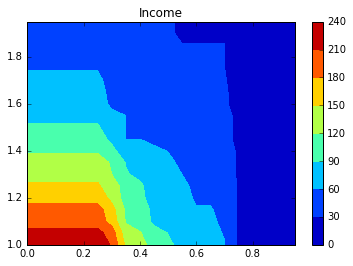

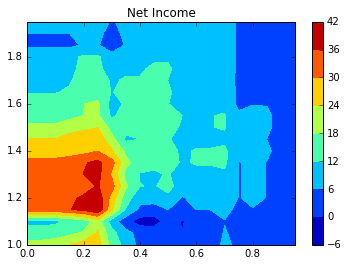

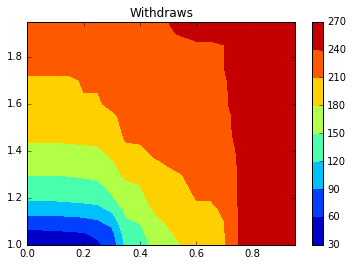

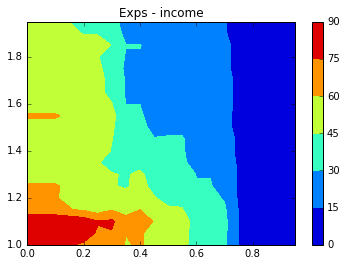

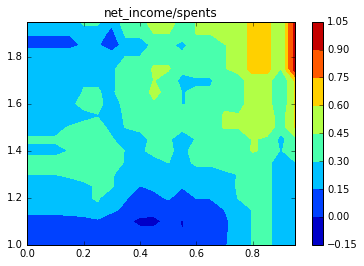

In [205]:
import matplotlib.pyplot as plt
g_n_incomes = np.array(g_incomes).reshape(len(g_e_range),len(g_z_range))
g_n_spent = np.array(g_spents).reshape(len(g_e_range),len(g_z_range))
g_n_withdraws = np.array(g_withdraws).reshape(len(g_e_range),len(g_z_range))
g_n_exps = np.array(g_exps).reshape(len(g_e_range),len(g_z_range))
Z, E =np.meshgrid(g_z_range,g_e_range)
CS = plt.contour = plt.contourf(Z,E,g_n_incomes)
plt.title("Income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_incomes-g_n_spent)
plt.title("Net Income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_withdraws)
plt.title("Withdraws")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E,g_n_exps - g_n_incomes)
plt.title("Exps - income")
cbar = plt.colorbar(CS)
plt.figure()
CS = plt.contour = plt.contourf(Z,E, (g_n_incomes-g_n_spent)/g_n_spent)
plt.title("net_income/spents")
cbar = plt.colorbar(CS)
plt.figure()

In [129]:
g_node_sizes=[g_best_size,g_best_size]

In [190]:
def getPrecisionMaxtrix(node_sizes,c):
    X, y = c.getH7(removeInsufficient=True)
    X_scaled = StandardScaler().fit_transform(X)
    _,_, proba_test,proba_y,_ = crossValidate2(node_sizes,X_scaled,y,dropout=g_best_dropout,fold=10)
    p_matrix = precisionMatrix(np.vstack(proba_test),np.vstack(proba_y)) 
    return p_matrix

In [191]:
g_p_matrix= getPrecisionMaxtrix(g_node_sizes,c)

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
Epoch 00030: early stopping
1221/1221 [==============================] - 0s     
Fold: 1, Class dist.: [539 298 384], val_loss: 1.015
Epoch 00031: early stopping
1221/1221 [==============================] - 0s     
Fold: 2, Class dist.: [539 298 384], val_loss: 0.990
Epoch 00035: early stopping
1222/1222 [==============================] - 0s     
Fold: 3, Class dist.: [539 299 3

In [192]:
g_p_matrix

,[lower,upper),h_Correct,h_Wrong,h_Precent,d_Correct,d_Wrong,d_Precent,a_Correct,a_Wrong,a_Precent
>80,0.8,1.0,37,13,0.740000,0,0,NaN,1,0,1.000000
60-80,0.6,0.8,209,114,0.647059,0,0,NaN,52,28,0.650000
50-60,0.5,0.6,84,87,0.491228,0,1,0.000000,86,69,0.554839
40-50,0.4,0.5,102,108,0.485714,3,12,0.200000,66,125,0.345550
30-40,0.3,0.4,64,123,0.342246,55,126,0.303867,75,148,0.336323
20-30,0.2,0.3,77,169,0.313008,213,626,0.253874,78,186,0.295455
<20,0.0,0.2,26,145,0.152047,61,261,0.189441,69,375,0.155405


In [134]:
def getTrainedModel(node_sizes,c):
    X, y = c.getH7(removeInsufficient=True)
    X_scaled = StandardScaler().fit_transform(X) 
    model = createModel(node_sizes,X_scaled.shape[1])
    earlyCallback = EarlyStopping(patience=g_patience,verbose=1)
    history = model.fit(X_scaled,y,verbose=0,nb_epoch=500, validation_split=0.1, callbacks=[earlyCallback])
    return model
    

In [135]:
g_model = getTrainedModel(g_node_sizes,c)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
Epoch 00019: early stopping


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [154]:
from sklearn.preprocessing import StandardScaler
def predictFuture(node_sizes,c,p_matrix,model):
    X_test,y_test = c.getH7(removeInsufficient = True,future=True)
    X_test_scaled = StandardScaler().fit_transform(X_test)
    proba_y = model.predict_proba(X_test_scaled)
   
    def getTestDf (X_test,proba_y,c):
        decoded = oneHotDecode(c, X_test)
        homeNames = c.inverseTeamMapping(decoded[:,0])
        awayNames = c.inverseTeamMapping(decoded[:,1])
        names = np.array([homeNames,awayNames]).T
        return pd.DataFrame(np.hstack([names,proba_y]),columns=['HomeTeam','AwayTeam','H_prob','D_prob','A_prob'])
   
    test_df = getTestDf(X_test,proba_y,c)
    test_df = test_df.sort(columns="HomeTeam")
    originDf = c.df[c.df["Future"]==1].sort(columns="HomeTeam")
    test_df['JocH']=originDf['JocH'].values
    test_df['JocD']=originDf['JocD'].values
    test_df['JocA']=originDf['JocA'].values
    fproba_mat,odd_mat,_= formatMatrixs(test_df,p_matrix)
    return fproba_mat,odd_mat,test_df
    
    

In [155]:
fproba_mat,odd_mat,test_df=predictFuture(g_node_sizes,c,g_p_matrix,g_model)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish
9/9 [==============================] - 0s

/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [164]:
spent,income,expectation,withdraw,total,receipt = strategy4(fproba_mat,odd_mat,None,test_df,z=0.2,e=1.6)

In [165]:
receipt

,home,away,odd of choice,choice,result,Hp,Dp,Ap


In [ ]:
c.df[["Date","HomeTeam","AwayTeam"]].sort(columns ="Date",ascending = False)


In [170]:
from sklearn.ensemble import RandomForestClassifier

In [185]:
forest =RandomForestClassifier(n_estimators = 10000)

In [186]:
forest.fit(X_scaled,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
    X_test,y_test = c.getH7(removeInsufficient = True,future=True)
    X_test_scaled = StandardScaler().fit_transform(X_test)

start format
[['HS_Acc' 'HST_Acc' 'H_poss_Acc' 'H_atk_3rd_Acc' 'H_atk_3rd_tot_Acc'
  'H_red_goal_Acc' 'H_red_on_Acc' 'H_red_tot_Acc' 'H_chance_goal_Acc'
  'H_chance_tot_Acc' 'H_successful_tackle_Acc' 'H_tackle_tot_Acc'
  'H_successful_clearance_Acc' 'H_clearance_tot_Acc' 'H_interceptions_Acc'
  'H_blocks_Acc']
 ['AS_Acc' 'AST_Acc' 'A_poss_Acc' 'A_atk_3rd_Acc' 'A_atk_3rd_tot_Acc'
  'A_red_goal_Acc' 'A_red_on_Acc' 'A_red_tot_Acc' 'A_chance_goal_Acc'
  'A_chance_tot_Acc' 'A_successful_tackle_Acc' 'A_tackle_tot_Acc'
  'A_successful_clearance_Acc' 'A_clearance_tot_Acc' 'A_interceptions_Acc'
  'A_blocks_Acc']]
finish


/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:223: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/y/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:231: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [188]:
result =np.array(forest.predict_proba(X_test))

In [189]:
result[:,:,1].T

array([[ 0.4075,  0.3284,  0.2641],
       [ 0.3526,  0.3407,  0.3067],
       [ 0.3954,  0.3455,  0.2591],
       [ 0.3978,  0.3391,  0.2631],
       [ 0.403 ,  0.3453,  0.2517],
       [ 0.3905,  0.3458,  0.2637],
       [ 0.4031,  0.3336,  0.2633],
       [ 0.3597,  0.3373,  0.303 ],
       [ 0.4072,  0.3307,  0.2621]])